# Using subspaces

Often times, we encounter operators that have some conservation law. `dynamite` can take advantage of conservation laws in the $\sigma_z$ product state basis by working in a restricted subspace.

For this demonstration, we'll use the following long-range XX+Z model:

In [1]:
from dynamite.operators import sigmax, sigmaz, index_sum, op_sum

# the None default argument will be important later
def build_hamiltonian(L):
    interaction = op_sum(index_sum(sigmax(0)*sigmax(i), size=L) for i in range(1,L))
    uniform_field = 0.5*index_sum(sigmaz(), size=L)
    return interaction + uniform_field

# look at an example
build_hamiltonian(20)

dynamite.Operator on 20 spins:
index_sum(σx[0]*σx[1], sites 0 - 18) + index_sum(σx[0]*σx[2], sites 0 - 17) + index_sum(σx[0]*σx[3], sites 0 - 16) + ... + 0.500*[index_sum(σz[0], sites 0 - 19)]

If we look at the nonzero structure of the matrix, it's not at all clear that it's block diagonal:

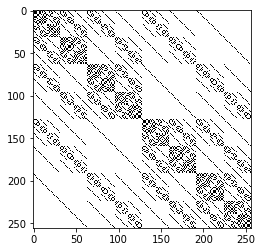

In [2]:
%matplotlib inline
build_hamiltonian(8).spy()

This is a graphical representation of the matrix, where each black dot represents a nonzero element.

It turns out it is block-diagonal, we just need to reorder the rows. In fact, we can see by inspection of the Hamiltonian's definition that the X terms are always two-body, meaning that parity is conserved in the Z product state basis. We can easily apply this subspace in dynamite:

In [3]:
H = build_hamiltonian(20)

print('full space dimension:     ', H.dim)

from dynamite.subspaces import Parity
H.subspace = Parity('even')

print('parity subspace dimension:', H.dim)

full space dimension:      (1048576, 1048576)
parity subspace dimension: (524288, 524288)


As expected, the dimension was cut in half! The same subspace can be applied to states, and even globally:

In [4]:
from dynamite.states import State

ket = State(L=20, subspace=Parity('even'))
print('vector length:', ket.vec.size)

vector length: 524288


Let's set everything globally so we don't have to keep writing lengths and subspaces everywhere.

In [5]:
from dynamite import config
config.L = 20
config.subspace = Parity('even')

In [6]:
# now we never have to specify the subspace! and we only need to give
# build_hamiltonian the value of L so it knows the longest long-range interaction
H = build_hamiltonian(config.L)
ket = State()
print('H size:', H.L)
print('H subspace:', H.subspace)
print('ket subspace:', ket.subspace)

H size: 20
H subspace: <dynamite.subspaces.Parity object at 0x7fb5111b8e48>
ket subspace: <dynamite.subspaces.Parity object at 0x7fb5111b8e48>


### The Auto subspace

In some cases, it might not be clear if the Hamiltonian is block diagonal. In other cases, the subspace might just might be something that is not built in to `dynamite`. Conservation of total magnetization is a good example. Let's take the XXYY model:

In [7]:
from dynamite.operators import sigmay

def build_XXYY(L=None):
    return index_sum(sigmax(0)*sigmax(1) + sigmay(0)*sigmay(1), size=L)

# our operator size is still set from config
build_XXYY()

dynamite.Operator on 20 spins:
index_sum(σx[0]*σx[1] + σy[0]*σy[1], sites 0 - 18)

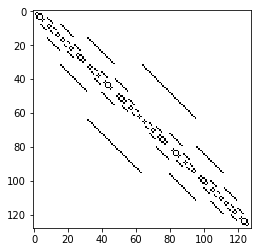

In [8]:
config.L = 8
build_XXYY().spy()

How can we take advantage of conservation of total magnetization? With the Auto subspace:

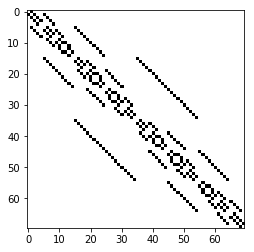

In [9]:
from dynamite.subspaces import Auto
H = build_XXYY()

# we want the subspace conserved by Hamiltonian H, that contains 
# the state with four up spins followed by four down spins
subspace = Auto(H, 'UUUUDDDD')

H.subspace = subspace
H.spy()

As expected, the dimension has been reduced significantly! In fact, it has been reduced to 8 choose 4, which is what we would expect for total spin conservation:

In [10]:
from math import factorial
def choose(n, k):
    return factorial(n) // (factorial(k)*factorial(n-k))

print('subspace dimension:', subspace.get_dimension())
print('8 choose 4:        ', choose(8, 4))

subspace dimension: 70
8 choose 4:         70


Or we can do a different total spin sector:

In [11]:
# only three down spins
subspace = Auto(H, 'UUUUUDDD')

print('subspace dimension:', subspace.get_dimension())
print('8 choose 3:        ', choose(8, 3))

subspace dimension: 56
8 choose 3:         56


Under the hood, `dynamite` finds these subspaces by viewing the Hamiltonian as the adjacency matrix for a graph, and finding the connected component of that graph that includes the given state.